In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import pyccl as ccl
import scipy
import importlib as imp
import astropy.io.fits as fits
import yaml
import time

# SRD Binning
import srd_redshift_distributions as srd
import binning

# import main.py from TJPCov folder
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
print(sacc.standard_types)

- cl_00
- cl_0e
- cl_0b
- cl_e0
- cl_b0
- cl_ee
- cl_eb
- cl_be
- cl_bb
- xi_00
- xi_0e
- xi_0b
- xi_e0
- xi_b0
- xi_plus_re
- xi_plus_im
- xi_minus_re
- xi_minus_im
- count
- cluster_counts
- cluster_mean_log_mass
- cluster_shear
- clusterGalaxy_densityConvergence_cl
- clusterGalaxy_densityConvergence_xi
- clusterGalaxy_densityShear_cl_b
- clusterGalaxy_densityShear_cl_e
- clusterGalaxy_densityShear_xi_t
- clusterGalaxy_densityShear_xi_x
- clusterGalaxy_density_cl
- clusterGalaxy_density_xi
- cluster_density_cl
- cluster_density_xi
- cluster_mass_count_wl
- cluster_mass_count_xray
- cmbCluster_polarizationDensity_cl_b
- cmbCluster_polarizationDensity_cl_e
- cmbCluster_polarizationDensity_xi_t
- cmbCluster_polarizationDensity_xi_x
- cmbCluster_temperatureDensity_cl
- cmbCluster_temperatureDensity_xi
- cmbCluster_convergenceDensity_cl
- cmbCluster_convergenceDensity_xi
- cmbGalaxy_convergenceDensity_cl
- cmbGalaxy_convergenceDensity_xi
- cmbGalaxy_convergenceShear_cl_b
- cmbGalaxy_conve

In [3]:
# load in cosmology object from yaml
cosmo = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.96,
                          A_s = 2.01e-9)

(5, 500)
(500,)


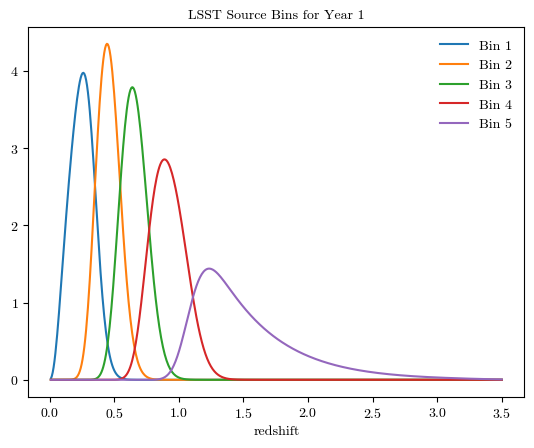

In [4]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 500)
forecast_years = ["1", "10"]  # Assuming integers are appropriate

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
# print(redshift_distribution["sources"].keys())


bins = {
    "sources": {},
    "lenses": {}
}

# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=True,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=True,
                                                           save_file=False)


for bin_idx, (key, data) in enumerate(bins["sources"]["1"].items()):
    plt.plot(redshift_range,
            data, 
            label=f"Bin {key+1}")
    plt.xlabel("redshift")
    plt.title(f"LSST Source Bins for Year 1", fontsize=10)
    plt.legend(frameon=False, ncol=1)

#(5, 256)
Binned_distribution = [list(bins["sources"]["1"].items())[0][1]]
for i in range(4):
    Binned_distribution = np.append(Binned_distribution,\
               [list(bins["sources"]["1"].items())[i+1][1]], axis=0)
    
print(Binned_distribution.shape)
print(redshift_range.shape)

(5, 500)


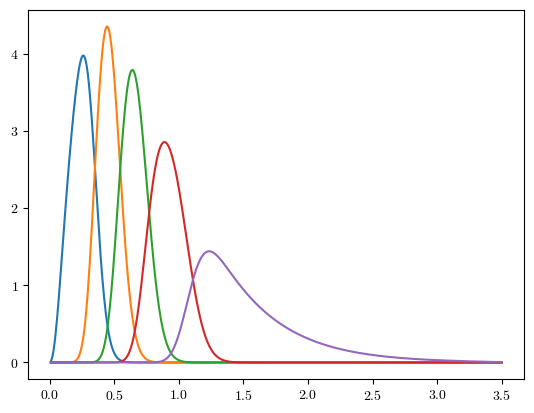

In [5]:
## TEST2: Plots to check binned redshift distribution

z = redshift_range

#plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[3])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])

print(Binned_distribution.shape)

In [6]:
# th vectors
Jch_th = np.array([0.6076,0.8570,1.2065,1.7016,2.3966,
                    3.3759,4.7557,6.6999,9.4412,13.3010,18.7420,
                    26.4070,37.2070,52.4230,73.8620,104.0600,
                    146.6100,206.5400,290.9400,409.7900])

Test_th = np.geomspace(0.602,410,20)

# modify to use different th vector
th = Jch_th

# Niko redshifts
#source_zdata = np.loadtxt('/home/b7009348/SkySim5000_Covs/redshifts/nz_sources_srd_5bins')

# get data for lens bin 1
z_src = z

src0 = Binned_distribution[0]
src1 = Binned_distribution[1]
src2 = Binned_distribution[2]
src3 = Binned_distribution[3]
src4 = Binned_distribution[4]

ell_bins = np.flip(180/(th/60.))

src_bins = [src0, src1]#, src2, src3, src4]

s = sacc.Sacc()

for i, bin1 in enumerate(src_bins):
    for j, bin2 in enumerate(src_bins):
        
        s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)

        # construct Cl_gM for sacc file
        shearA = ccl.WeakLensingTracer(cosmo, dndz=(z_src, bin1), has_shear=True)
        shearB = ccl.WeakLensingTracer(cosmo, dndz=(z_src, bin2), has_shear=True)

        Cl = ccl.angular_cl(cosmo, shearA, shearB, ell_bins)

        # s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
        #                'src%d'%j, ell_bins, Cl, tracers_later=True)
        
        xip = ccl.correlation(cosmo, ell=ell_bins, 
                              C_ell=Cl, theta=th/60., type='GG+') # take theta in degrees
        
        xim = ccl.correlation(cosmo, ell=ell_bins, 
                              C_ell=Cl, theta=th/60., type='GG-') 
        
        s.add_theta_xi('galaxy_shear_xi_plus', 'src%d'%i, 
                       'src%d'%j, th, xip, tracers_later=True) # save in arcmins
        
        s.add_theta_xi('galaxy_shear_xi_minus', 'src%d'%i, 
                       'src%d'%j, th, xim, tracers_later=True)

s.save_fits('TJPconfig/cl_and_xi_data.fits', overwrite=True)

In [7]:
config = 'SRD_specs/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

# get matrix 
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
Rank None: ('src0', 'src0'), ('src0', 'src0')


/home/c2042999/PCA_env_cov/3.8.10/lib/python3.11/site-packages/tjpcov/covariance_builder.py:887: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Rank None: ('src0', 'src0'), ('src1', 'src0')
Rank None: ('src0', 'src0'), ('src1', 'src1')


/home/c2042999/PCA_env_cov/3.8.10/lib/python3.11/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


Rank None: ('src0', 'src0'), ('src2', 'src0')
Rank None: ('src0', 'src0'), ('src2', 'src1')
Rank None: ('src0', 'src0'), ('src2', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src0')
Rank None: ('src0', 'src0'), ('src3', 'src1')
Rank None: ('src0', 'src0'), ('src3', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src0')
Rank None: ('src0', 'src0'), ('src4', 'src1')
Rank None: ('src0', 'src0'), ('src4', 'src2')
Rank None: ('src0', 'src0'), ('src4', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src4')
Rank None: ('src1', 'src0'), ('src1', 'src0')
Rank None: ('src1', 'src0'), ('src1', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src0')
Rank None: ('src1', 'src0'), ('src2', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src0')
Rank None: ('src1', 'src0'), ('src3', 'src1')
Rank None: ('src1', 'src0'), ('src3', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src3')
Rank None: ('src1', 'src0'), ('src

/tmp/ipykernel_2310645/4199694443.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov)))


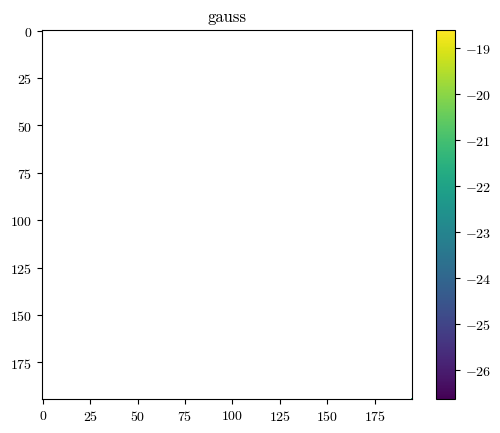

In [8]:
# You can also get the covariance terms (Gaussian, SSC, ...) independently
covs = gauss_calc.get_covariance_terms()

for term, cov in covs.items():
    plt.imshow(np.log10(np.abs(cov)))
    plt.colorbar()
    plt.title(term)
    plt.show()

(195, 195)


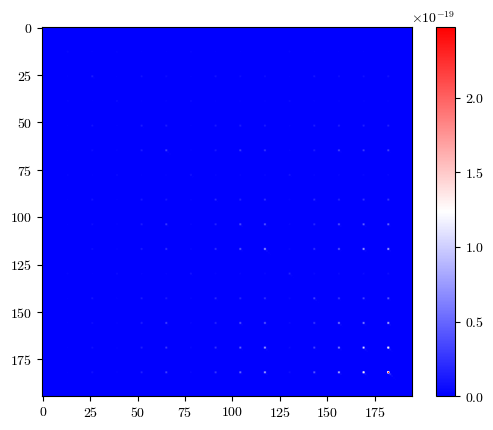

In [9]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

/tmp/ipykernel_3746654/4199694443.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov)))


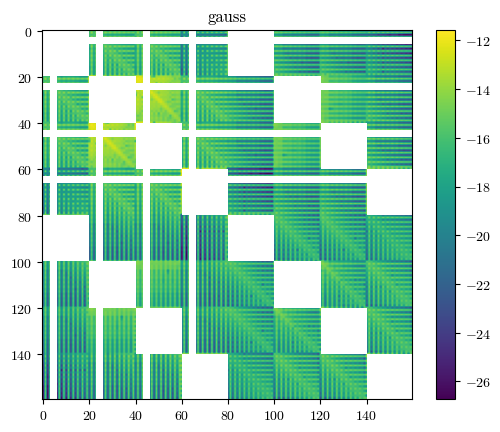

In [21]:
# You can also get the covariance terms (Gaussian, SSC, ...) independently
covs = gauss_calc.get_covariance_terms()

for term, cov in covs.items():
    plt.imshow(np.log10(np.abs(cov)))
    plt.colorbar()
    plt.title(term)
    plt.show()